# 4위 모델 따라해보기 - FLAML와 이상치 제거를 사용한 와인 품질 분류
https://dacon.io/competitions/official/235840/codeshare/3836?page=1&dtype=recent

✨ 처음보는 모듈이 많아서 무작정 따라해보기로함 두근두근 ✨

In [1]:
!pip install catboost
!pip install kaggler
!pip install pendulum
!pip install flaml
!pip install shap

     |████████████████████████████████| 76.3 MB 1.2 MB/s 
     |████████████████████████████████| 822 kB 5.2 MB/s 
  Created wheel for kaggler: filename=Kaggler-0.9.13-cp37-cp37m-linux_x86_64.whl size=2963689 sha256=963169b1512cf75f8c1224bf3354f8e8f4806725e5cef3668c8a353c864edecb
  Stored in directory: /root/.cache/pip/wheels/64/38/23/298e2f6a012a8ae187cf100410865a2cdd434aed5a75a42cfe
  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-py3-none-any.whl size=7845 sha256=c95780c466d0b4f00c0146b2dd7e9e90f9327a0333b481ca1698f85b48b0e3bf
  Stored in directory: /root/.cache/pip/wheels/56/41/5b/0c6d42b3604a5c823d8922564c4708f84962fa7f2f4facfa6d
Successfully built kaggler ml-metrics
     |████████████████████████████████| 155 kB 5.3 MB/s 
     |████████████████████████████████| 489 kB 46.3 MB/s 
     |████████████████████████████████| 137 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 40.8 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3


# catboost란? 
## 범주형 변수처리에 성능이 좋은 부스팅 방법. 
* https://blog.naver.com/remedies/222455892119 
* https://blog.naver.com/wltjd54/222512755517
* https://catboost.ai/

# XGboost
* https://xgboost.readthedocs.io/en/latest/python/python_api.html

# LightGBM
* https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html


# pendulum 
### datetime 다루는 모듈 
* https://pendulum.eustace.io/docs/ 
* https://minwook-shin.github.io/python-ease-datetimes-manipulation-using-pendulum/


# AutoML flaml 
* https://microsoft.github.io/FLAML/

# shap 
### shap value 주요변수추출
* https://blog.naver.com/jaehong7719/221955293764
* https://moondol-ai.tistory.com/394
* https://blog.naver.com/jaehong7719/221956713573
* https://blog.naver.com/hkyku9/222374630017

벌써부터 엄청 많은 걸 배웠다;; 😅 

# TABNET
* https://wsshin.tistory.com/5

#auto-sklearn
* https://automl.github.io/auto-sklearn/master/

AutoML
* **API** https://github.com/microsoft/FLAML
* http://incredible.ai/machine-learning/2019/12/14/AutoML/

# azure machine learning 
https://docs.microsoft.com/ko-kr/azure/machine-learning/

In [65]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime
np.random.seed(0)

from kaggler.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

from tqdm.notebook import tqdm  
import os, re
import glob
import calendar

from flaml import AutoML
import statsmodels.api as sm
import pendulum
import warnings
warnings.filterwarnings(action='ignore')

* tqdm
`from tqdm.notebook import tqdm`
* 진행률 표시해주는 라이브러리 
* https://blog.naver.com/jang0_0yw/222420637332

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'
%config inlinebackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_row', 526)
pd.set_option('display.max_columns', 100)

In [67]:
path = '/content/drive/MyDrive/Colab Notebooks/DACON/WINE_classification/data/'
train = pd.read_csv(path +'train.csv')
test = pd.read_csv(path +'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [68]:
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

* 열이름 공백 처리

In [69]:
train['quality'].unique()

array([6, 7, 5, 8, 4])

In [70]:
def data_feature(df):
    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])

    return df

`!pip install kaggler` 
<br>
`from kaggler.preprocessing import LabelEncoder`
* 캐글에서 지원하는 라벨인코더인듯?

`from sklearn.preprocessing import LabelEncoder`
* 사이킷런에 있는거랑 뭐가 다른가 ? 🤔

In [71]:
train = data_feature(train)
test = data_feature(test)

In [72]:
train_0 = train[train['type'] == 0]
train_1 = train[train['type'] == 1]
train_0.drop(columns=['id'], inplace=True)
train_1.drop(columns=['id'], inplace=True)
train_0.reset_index(drop=True, inplace=True)
train_1.reset_index(drop=True, inplace=True)

In [73]:
train_0

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type,quality
0,8.4,0.370,0.43,2.3,0.063,12.0,19.0,0.99550,3.17,0.81,11.2,0,7
1,6.9,0.410,0.33,2.2,0.081,22.0,36.0,0.99490,3.41,0.75,11.1,0,6
2,6.8,0.590,0.06,6.0,0.060,11.0,18.0,0.99620,3.41,0.59,10.8,0,7
3,7.2,0.655,0.03,1.8,0.078,7.0,12.0,0.99587,3.34,0.39,9.5,0,5
4,9.6,0.560,0.23,3.4,0.102,37.0,92.0,0.99960,3.30,0.65,10.1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,6.3,0.470,0.00,1.4,0.055,27.0,33.0,0.99220,3.45,0.48,12.3,0,6
774,6.5,0.340,0.27,2.8,0.067,8.0,44.0,0.99384,3.21,0.56,12.0,0,6
775,6.4,0.390,0.33,3.3,0.046,12.0,53.0,0.99294,3.36,0.62,12.2,0,6
776,7.8,0.560,0.19,2.0,0.081,17.0,108.0,0.99620,3.32,0.54,9.5,0,5


# **이상치 확인 및 제거**

In [74]:
for i in train['quality'].unique():
    globals()['train_{}'.format(i)] = train[train['quality'] == i]
    locals()['train_{}'.format(i)].drop(columns=['id'], inplace=True)
    locals()['train_{}'.format(i)].reset_index(drop=True, inplace=True)

In [75]:
for i in train['quality'].unique():
    for j in train['type'].unique():
        globals()['train_{}'.format(i)] = train[train['quality'] == i]
    locals()['train_{}'.format(i)].drop(columns=['id'], inplace=True)
    locals()['train_{}'.format(i)].reset_index(drop=True, inplace=True)

* type 별, quality 별 데이터프레임 생성.. 왜 globals locals를 썼을까;ㅅ; 
* globals()['train_4']나 locals()['train_4']나 똑같은거같은데..
* globals() 전역 , locals() 지역변수 : dict 자료형

## quality 별 특성 확인

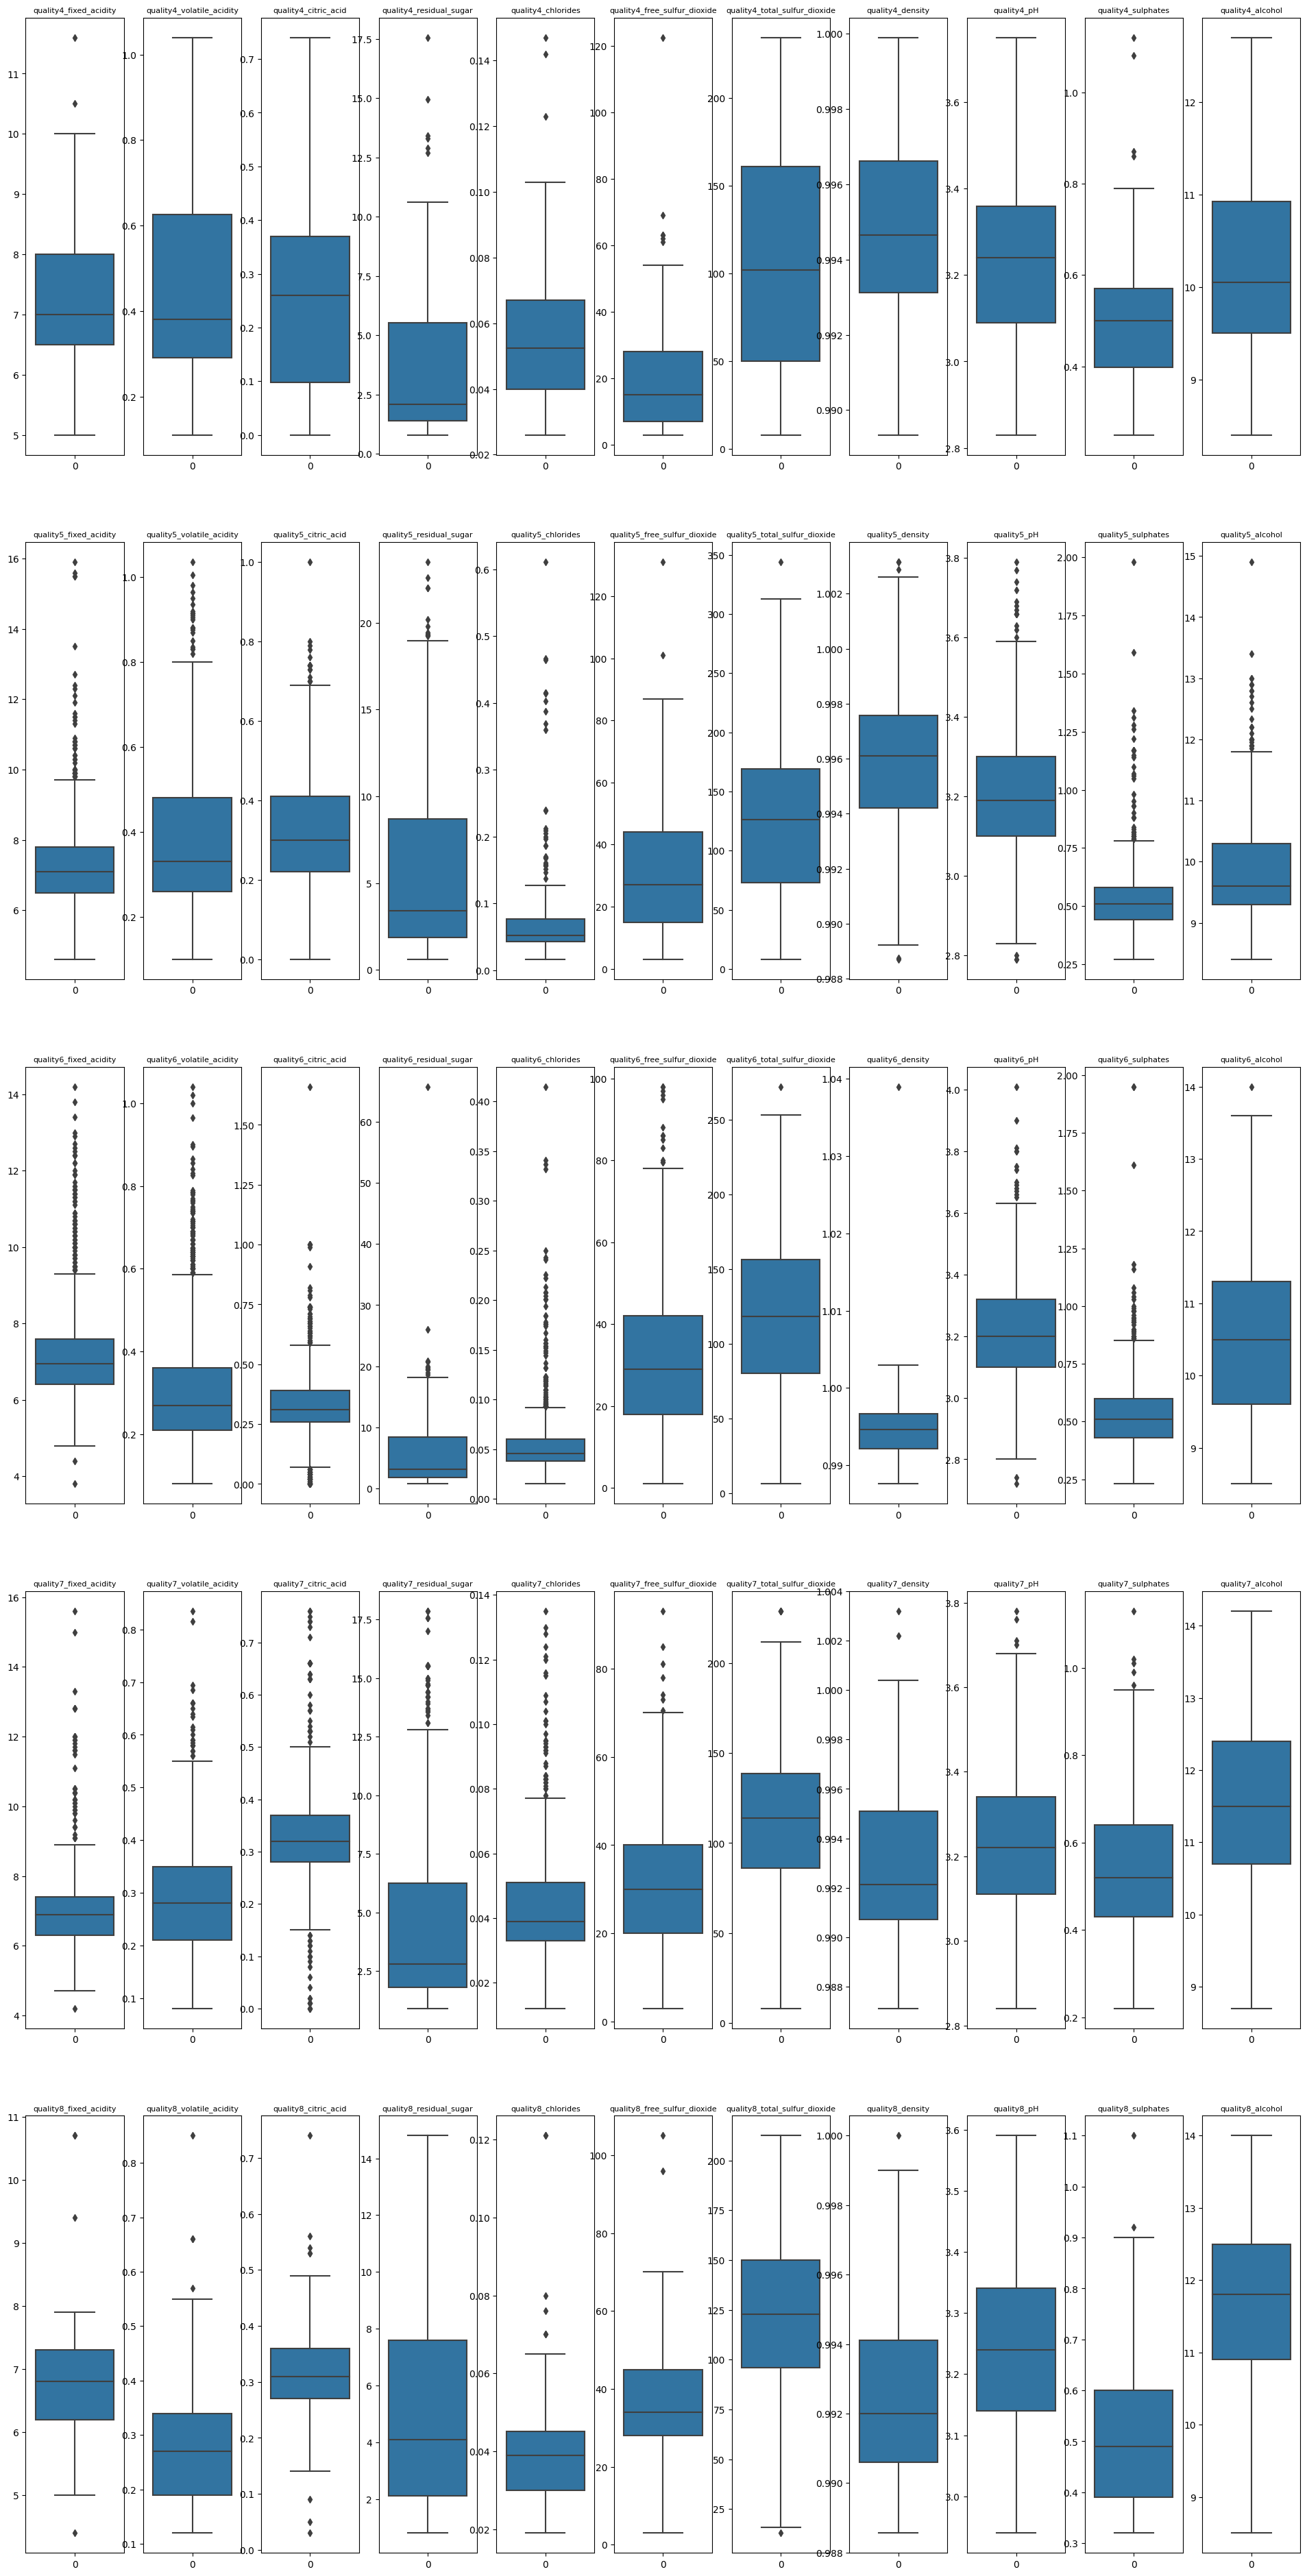

In [76]:
plt.figure(figsize=(24,49))
count = 1
for i in sorted(train['quality'].unique()):
    for j in test.columns[1:12]:
        plt.subplot(5,11,count)
        p = sns.boxplot(data=locals()['train_{}'.format(i)][j])
        p.set_title(f'quality{i}_{j}', fontsize=8)
        count+=1
plt.show()

In [77]:
outlier_idx = set()

* 5~ 7등급에 이상치가 월등히 많음
* 이상치를 눈으로 확인하고 이상치에 해당하는 인덱스를 저장

In [78]:
# quality = 4
for i in train[train.quality == 4].fixed_acidity[train[train.quality == 4].fixed_acidity >= 11].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].volatile_acidity[train[train.quality == 5].volatile_acidity >= 0.92].index.values:
#     outlier_idx.add(i)
# for i in train[train.quality == 5].citric_acid[train[train.quality == 5].citric_acid >= 0.9].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 4].residual_sugar[train[train.quality == 4].residual_sugar >= 12.5].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 4].chlorides[train[train.quality == 4].chlorides >= 0.12].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 4].free_sulfur_dioxide[train[train.quality == 4].free_sulfur_dioxide >= 120].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].density[train[train.quality == 5].density >= 1.03].index.values:
#     outlier_idx.add(i)
# for i in train[train.quality == 5].PH[train[train.quality == 5].PH >= 3.9].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 4].sulphates[train[train.quality == 4].sulphates >= 1.0].index.values:
    outlier_idx.add(i)


# quality = 5
for i in train[train.quality == 5].fixed_acidity[train[train.quality == 5].fixed_acidity >= 14].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].volatile_acidity[train[train.quality == 5].volatile_acidity >= 0.92].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 5].citric_acid[train[train.quality == 5].citric_acid >= 0.9].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].residual_sugar[train[train.quality == 5].residual_sugar >= 60].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 5].chlorides[train[train.quality == 5].chlorides >= 0.30].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 5].free_sulfur_dioxide[train[train.quality == 5].free_sulfur_dioxide >= 120].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].density[train[train.quality == 5].density >= 1.03].index.values:
#     outlier_idx.add(i)
# for i in train[train.quality == 5].PH[train[train.quality == 5].PH >= 3.9].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 5].sulphates[train[train.quality == 5].sulphates >= 1.50].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 5].alcohol[train[train.quality == 5].alcohol >= 14].index.values:
    outlier_idx.add(i)

# quality = 6
for i in train[train.quality == 6].fixed_acidity[train[train.quality == 6].fixed_acidity >= 13].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].volatile_acidity[train[train.quality == 6].volatile_acidity >= 0.92].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].citric_acid[train[train.quality == 6].citric_acid >= 1.25].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].residual_sugar[train[train.quality == 6].residual_sugar >= 60].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].chlorides[train[train.quality == 6].chlorides >= 0.30].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].free_sulfur_dioxide[train[train.quality == 6].free_sulfur_dioxide >= 90].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].density[train[train.quality == 6].density >= 1.03].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].pH[train[train.quality == 6].pH >= 3.9].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].sulphates[train[train.quality == 6].sulphates >= 1.50].index.values:
    outlier_idx.add(i)

# quality = 7
for i in train[train.quality == 7].fixed_acidity[train[train.quality == 7].fixed_acidity >= 14].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].volatile_acidity[train[train.quality == 7].volatile_acidity >= 0.75].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].citric_acid[train[train.quality == 7].citric_acid >= 0.7].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].residual_sugar[train[train.quality == 7].residual_sugar >= 16].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].chlorides[train[train.quality == 7].chlorides >= 0.11].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].free_sulfur_dioxide[train[train.quality == 7].free_sulfur_dioxide >= 90].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].density[train[train.quality == 7].density >= 1.002].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].sulphates[train[train.quality == 7].sulphates >= 1.1].index.values:
    outlier_idx.add(i)

# quality = 8
for i in train[train.quality == 8].fixed_acidity[train[train.quality == 8].fixed_acidity >= 9].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].volatile_acidity[train[train.quality == 8].volatile_acidity >= 0.7].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].citric_acid[train[train.quality == 8].citric_acid >= 0.6].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].chlorides[train[train.quality == 8].chlorides >= 0.1].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].free_sulfur_dioxide[train[train.quality == 8].free_sulfur_dioxide >= 80].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].sulphates[train[train.quality == 8].sulphates >= 1.0].index.values:
    outlier_idx.add(i)

In [79]:
len(outlier_idx)

86

In [80]:
train.drop(outlier_idx, axis=0, inplace=True)

In [81]:
train = train.reset_index(drop=True)

* drop=True 옵션이 있다는걸 알게됨

In [63]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

# shap values

In [82]:
import numpy as np
import shap
def get_columns(model, X_test, train, del_col_nm='quality'):
  explainer = shap.Explainer(model._model)
  shap_values = explainer(X_test)
  vals = np.abs(shap_values.values).mean(0)
  cols = list(train.columns)
  cols.remove(del_col_nm)
  feature_importance = pd.DataFrame(list(zip(cols, vals)), columns=['col_name','feature_importance_vals'])
  feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
  return feature_importance[feature_importance['feature_importance_vals'] > 1]['col_name'].values

'중식계' 는 다른코드에서 사용한 default값인듯ㅋㅋ..

In [83]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def run_kfold(train, test, selected_cols=[], target_col='중식계'):
    folds=KFold(n_splits=5, shuffle=True, random_state=2021)
    outcomes=[]
    model = None
    sub=[]

    X = np.array(train.drop(columns=[target_col]))
    cols = list(train.columns)
    cols.remove(target_col)
    X_test = np.array(test[cols])
    y = np.array(train[target_col])

    # 정규화
    standardScaler = StandardScaler()
    standardScaler.fit(X)
    X = standardScaler.transform(X)

    X_test = standardScaler.transform(X_test) # 정규화
    cols_import = []

    for n_fold, (train_index, val_index) in enumerate(folds.split(X)):
        print(n_fold, 'fold started =========================================')
        
        y_train = y[train_index]
        X_train = X[train_index]

        y_val = y[val_index]
        X_val = X[val_index]

        # 첫번째 루프때는 AutoML 초기화 후 fit
        if n_fold == 0:
          automl = AutoML()
          automl_settings = {
              "time_budget": 360,  # in seconds
              "metric": 'mae',
              "task": 'regression'
          }
          automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)
          model = automl.model
        else:
          model.fit(X_train, y_train, 
                    eval_set=[(X_val, y_val)],
                        eval_metric='mae', 
                    early_stopping_rounds=10
                    ) 
        
        pred1 = model.predict(X_test)
        
        # 선택된 특성이 없으면 shap values 추가
        if len(selected_cols) == 0:
          cols_import += list(get_columns(model, X_test, train=train, del_col_nm=target_col))
        sub.append(pred1)
    return sub, model, X_test, set(cols_import)

In [84]:
my_submission, model, X_test, cols_import = run_kfold(train, test, selected_cols=[], target_col='quality')

[flaml.automl: 12-12 05:10:23] {1943} INFO - task = regression
[flaml.automl: 12-12 05:10:23] {1945} INFO - Data split method: uniform
[flaml.automl: 12-12 05:10:23] {1949} INFO - Evaluation method: holdout
[flaml.automl: 12-12 05:10:23] {2019} INFO - Minimizing error metric: mae
[flaml.automl: 12-12 05:10:23] {2071} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-12 05:10:23] {2311} INFO - iteration 0, current learner lgbm


0 fold started =========================================


[flaml.automl: 12-12 05:10:23] {2425} INFO - Estimated sufficient time budget=3029s. Estimated necessary time budget=26s.
[flaml.automl: 12-12 05:10:23] {2505} INFO -  at 0.3s,	estimator lgbm's best error=0.6019,	best estimator lgbm's best error=0.6019
[flaml.automl: 12-12 05:10:23] {2311} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-12 05:10:23] {2505} INFO -  at 0.4s,	estimator lgbm's best error=0.6019,	best estimator lgbm's best error=0.6019
[flaml.automl: 12-12 05:10:23] {2311} INFO - iteration 2, current learner lgbm
[flaml.automl: 12-12 05:10:23] {2505} INFO -  at 0.4s,	estimator lgbm's best error=0.5785,	best estimator lgbm's best error=0.5785
[flaml.automl: 12-12 05:10:23] {2311} INFO - iteration 3, current learner lgbm
[flaml.automl: 12-12 05:10:23] {2505} INFO -  at 0.4s,	estimator lgbm's best error=0.5502,	best estimator lgbm's best error=0.5502
[flaml.automl: 12-12 05:10:23] {2311} INFO - iteration 4, current learner lgbm
[flaml.automl: 12-12 05:10:23] {2505} 

1 fold started =========================================


TypeError: ignored

## TypeError: fit() got an unexpected keyword argument 'eval_set'
* 2번째 fold부터 에러떠서 API 확인 함 (https://github.com/microsoft/FLAML) <br>
* model이 선택되었을 때 lgbm이나 xgboost가 아닐 경우 나타나는 에러
* 2번째 폴드부터 fit함수 내부 3줄 주석처리 하면 해결된다고 함.
```
eval_set=[(X_val, y_val)],
eval_metric='mae', 
early_stopping_rounds=10
```

## Q. 분류인데 왜 "task": 'regression'를 사용하는지? 
### A. 대회가 classification 모델이지만 품질이라는 변수가 딱 떨어지지 않을 수 있을 것이라고 생각하였기에 regression으로 모델을 돌리게 되었습니다.
* 로그파일도 만들어 주는것 같아서 추가 ` "log_file_name": "wine.log",`
*  gpu 옵션도 추가해봤다 ` "gpu_per_trial": 1,`

In [93]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def run_kfold(train, test, selected_cols=[], target_col='중식계'):
    folds=KFold(n_splits=5, shuffle=True, random_state=2021)
    outcomes=[]
    model = None
    sub=[]

    X = np.array(train.drop(columns=[target_col]))
    cols = list(train.columns)
    cols.remove(target_col)
    X_test = np.array(test[cols])
    y = np.array(train[target_col])

    # 정규화
    standardScaler = StandardScaler()
    standardScaler.fit(X)
    X = standardScaler.transform(X)

    X_test = standardScaler.transform(X_test) # 정규화
    cols_import = []

    for n_fold, (train_index, val_index) in enumerate(folds.split(X)):
        print(n_fold, 'fold started =========================================')
        
        y_train = y[train_index]
        X_train = X[train_index]

        y_val = y[val_index]
        X_val = X[val_index]

        # 첫번째 루프때는 AutoML 초기화 후 fit
        if n_fold == 0:
          automl = AutoML()
          automl_settings = {
              "time_budget": 360,  # in seconds
              "metric": 'mae',
              "task": 'regression',
              "log_file_name": "wine.log",
              "gpu_per_trial": 1,
          }
          automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)
          model = automl.model
        else:
          model.fit(X_train=X_train, y_train=y_train,
                    eval_set=[(X_val, y_val)],
                     eval_metric='mae', 
                    early_stopping_rounds=10
                    ) 
        
        pred1 = model.predict(X_test)
        
        # 선택된 특성이 없으면 shap values 추가
        if len(selected_cols) == 0:
          cols_import += list(get_columns(model, X_test, train=train, del_col_nm=target_col))
        sub.append(pred1)
    return sub, model, X_test, set(cols_import)

In [94]:
my_submission, model, X_test, cols_import = run_kfold(train, test, selected_cols=[], target_col='quality')

[flaml.automl: 12-12 06:56:47] {1943} INFO - task = regression
[flaml.automl: 12-12 06:56:47] {1945} INFO - Data split method: uniform
[flaml.automl: 12-12 06:56:47] {1949} INFO - Evaluation method: holdout
[flaml.automl: 12-12 06:56:47] {2019} INFO - Minimizing error metric: mae
[flaml.automl: 12-12 06:56:47] {2071} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-12 06:56:47] {2311} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-12 06:56:48] {2425} INFO - Estimated sufficient time budget=137s. Estimated necessary time budget=1s.
[flaml.automl: 12-12 06:56:48] {2505} INFO -  at 0.0s,	estimator lgbm's best error=0.6019,	best estimator lgbm's best error=0.6019
[flaml.automl: 12-12 06:56:48] {2311} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-12 06:56:48] {2505} INFO -  at 0.1s,	estimator lgbm's best error=0.6019,	best estimator lgbm's best error=0.6019
[flaml.automl: 12-12 06:56:48

0 fold started =========================================


[flaml.automl: 12-12 06:56:48] {2505} INFO -  at 0.4s,	estimator extra_tree's best error=0.6180,	best estimator lgbm's best error=0.5785
[flaml.automl: 12-12 06:56:48] {2311} INFO - iteration 5, current learner lgbm
[flaml.automl: 12-12 06:56:48] {2505} INFO -  at 0.4s,	estimator lgbm's best error=0.5502,	best estimator lgbm's best error=0.5502
[flaml.automl: 12-12 06:56:48] {2311} INFO - iteration 6, current learner lgbm
[flaml.automl: 12-12 06:56:48] {2505} INFO -  at 0.5s,	estimator lgbm's best error=0.5502,	best estimator lgbm's best error=0.5502
[flaml.automl: 12-12 06:56:48] {2311} INFO - iteration 7, current learner lgbm
[flaml.automl: 12-12 06:56:48] {2505} INFO -  at 0.5s,	estimator lgbm's best error=0.5458,	best estimator lgbm's best error=0.5458
[flaml.automl: 12-12 06:56:48] {2311} INFO - iteration 8, current learner lgbm
[flaml.automl: 12-12 06:56:48] {2505} INFO -  at 0.5s,	estimator lgbm's best error=0.5458,	best estimator lgbm's best error=0.5458
[flaml.automl: 12-12 06

1 fold started =========================================
2 fold started =========================================
3 fold started =========================================
4 fold started =========================================


5번 학습-검증 결과 평균값으로 최종 prediction 결정

In [95]:
pred = np.mean(my_submission, axis=0)

In [96]:
sample_submission = pd.read_csv(path+'sample_submission.csv')
submission = sample_submission.copy()

In [97]:
submission['quality'] = pred

In [98]:
submission['quality'] = round(submission['quality'], 0)

In [99]:
submission.to_csv(path + 'automl.csv', index=False)


In [100]:
submission

,id,quality
0,1,6.0
1,2,6.0
2,3,6.0
3,4,6.0
4,5,5.0
...,...,...
3226,3227,5.0
3227,3228,6.0
3228,3229,5.0
3229,3230,7.0
